# Import & Load Data

In [4]:
import zipfile

zip_path = "/content/cancer diagnosis.zip"  # Replace with your ZIP file name
extract_path = "."  # Extract to the current directory

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [5]:
import os
import json
import math
import gc
import itertools
import warnings
from collections import Counter
from functools import partial

import cv2
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns  # Added for better visualization

from PIL import Image
from tqdm import tqdm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Suppress warnings
warnings.filterwarnings("ignore")


In [6]:
from pathlib import Path

def dataset_loader(directory, resize):
    """Load images from a directory, resize them, and return as a NumPy array."""
    img_list = []
    directory = Path(directory)

    for image_path in tqdm(directory.glob("*.png")):  # Load only PNG files
        try:
            img = cv2.imread(str(image_path), cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, (resize, resize))
            img_list.append(np.array(img))
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")

    return np.array(img_list, dtype=np.uint8)

# Load the datasets
benign_train = dataset_loader('/content/breast-cancer-dataset/Train/Benign', 224)
malign_train = dataset_loader('/content/breast-cancer-dataset/Train/Malignant', 224)
benign_test = dataset_loader('/content/breast-cancer-dataset/Test/Benign', 224)
malign_test = dataset_loader('/content/breast-cancer-dataset/Test/Malignant', 224)


640it [00:02, 220.92it/s]
640it [00:02, 297.41it/s]
120it [00:00, 252.45it/s]
120it [00:00, 217.60it/s]


# Data Processing

In [7]:
# Create labels as NumPy arrays with dtype `int`
benign_train_label = np.zeros(len(benign_train), dtype=int)
malign_train_label = np.ones(len(malign_train), dtype=int)
benign_test_label = np.zeros(len(benign_test), dtype=int)
malign_test_label = np.ones(len(malign_test), dtype=int)

In [8]:
# Merge train and test data
x_train = np.vstack([benign_train, malign_train])  # Stack along axis 0
y_train = np.hstack([benign_train_label, malign_train_label])  # Stack 1D arrays

x_test = np.vstack([benign_test, malign_test])
y_test = np.hstack([benign_test_label, malign_test_label])

In [9]:
# Set random seed for reproducibility
np.random.seed(42)

# Shuffle training data
shuffled_indices = np.random.permutation(len(x_train))  # Generates a shuffled index array
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

In [10]:
# Set random seed for reproducibility
np.random.seed(42)

# Shuffle test data
shuffled_indices = np.random.permutation(len(x_test))  # Generates a shuffled index array
x_test = x_test[shuffled_indices]
y_test = y_test[shuffled_indices]


In [11]:
# Convert labels to categorical format (One-Hot Encoding)
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


In [12]:

# Split dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train,
    test_size=0.2,
    random_state=11,
    stratify=y_train  # Ensures balanced class distribution
)

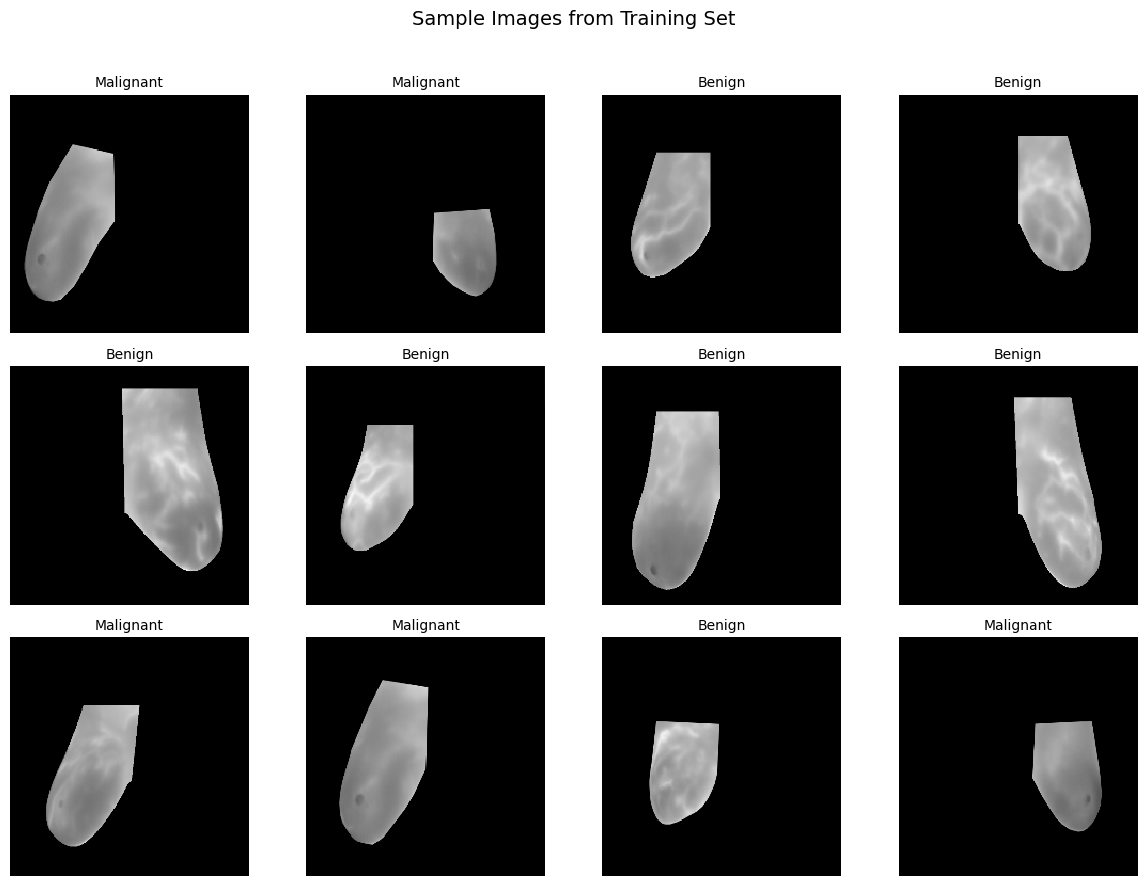

In [13]:
# Visualization of sample images
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 9))  # Adjust figure size for clarity
fig.suptitle("Sample Images from Training Set", fontsize=14)

for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i], interpolation='nearest')
    ax.axis("off")  # Remove axis for a cleaner look
    ax.set_title("Benign" if np.argmax(y_train[i]) == 0 else "Malignant", fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()

In [14]:
# Batch size for training
BATCH_SIZE = 16

# Image Augmentation for training data
train_generator = ImageDataGenerator(
    zoom_range=0.2,  # Reduced zoom for more realistic augmentation
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,  # Added shear transformation for better generalization
    width_shift_range=0.2,  # Small shifts for robustness
    height_shift_range=0.2,
    fill_mode="nearest"  # Ensures valid pixels after transformations
)


# Define Model and Evaluation

In [15]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def build_model(lr=5e-4):  # Adjusted LR based on your results
    # Load DenseNet201 with pretrained ImageNet weights
    backbone = DenseNet201(
        weights="imagenet",
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze the backbone (no fine-tuning needed)
    backbone.trainable = False

    model = Sequential([
        backbone,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(2, activation='softmax')  # Multi-class classification (2 classes)
    ])

    # Use gradient clipping for stability
    optimizer = Adam(learning_rate=lr, clipnorm=1.0)

    model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"]
    )

    return model

# Initialize model
model = build_model()
model.summary()

# 🔄 **Data Augmentation**
train_datagen = ImageDataGenerator(
    rescale=1/255.,  # Normalize images
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.6, 1.4],
    width_shift_range=0.3,
    height_shift_range=0.3,
)

val_datagen = ImageDataGenerator(rescale=1/255.)  # Only rescaling for validation

train_generator = train_datagen.flow(x_train, y_train, batch_size=32)
val_generator = val_datagen.flow(x_val, y_val, batch_size=32)

# 📉 **Callbacks: Reduce LR on Plateau & Early Stopping**
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# 🎯 **Train Model**
history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=10,  # Best result achieved at 10 epochs
    validation_data=val_generator,
    callbacks=[learn_control, early_stop]
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ (None, 7, 7, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1920)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1920)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1920)                │           7,680 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           3,842 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,333,506 (69.94 MB)

 Trainable params: 7,682 (30.01 KB)

 Non-trainable params: 18,325,824 (69.91 MB)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.5203 - loss: 0.8767 - val_accuracy: 0.5469 - val_loss: 0.7058 - learning_rate: 5.0000e-04
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 507ms/step - accuracy: 0.6173 - loss: 0.6993 - val_accuracy: 0.7500 - val_loss: 0.5666 - learning_rate: 5.0000e-04
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 550ms/step - accuracy: 0.6887 - loss: 0.6253 - val_accuracy: 0.8008 - val_loss: 0.5034 - learning_rate: 5.0000e-04
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 496ms/step - accuracy: 0.7089 - loss: 0.5581 - val_accuracy: 0.8164 - val_loss: 0.4696 - learning_rate: 5.0000e-04
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 529ms/step - accuracy: 0.6955 - loss: 0.5930 - val_accuracy: 0.8164 - val_loss: 0.4505 - learning_rate: 5.0000e-04
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 490ms/step - accuracy: 0.7284 - loss: 0.5557 - val_accuracy: 0.8281 - val_loss: 0.4272 - learning_rate: 5.0000e-04
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 494ms/step - accura

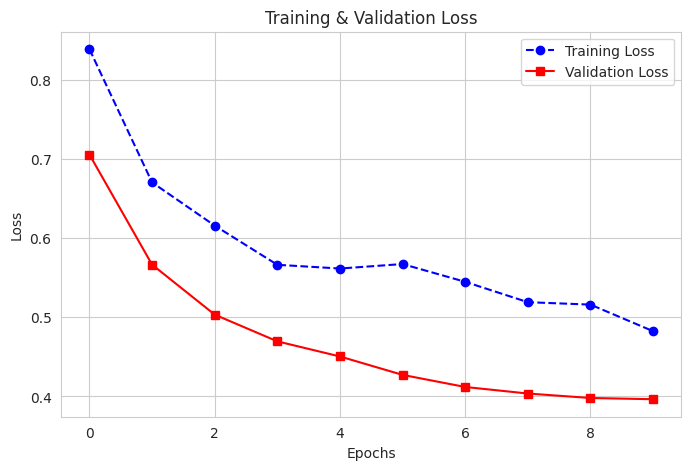

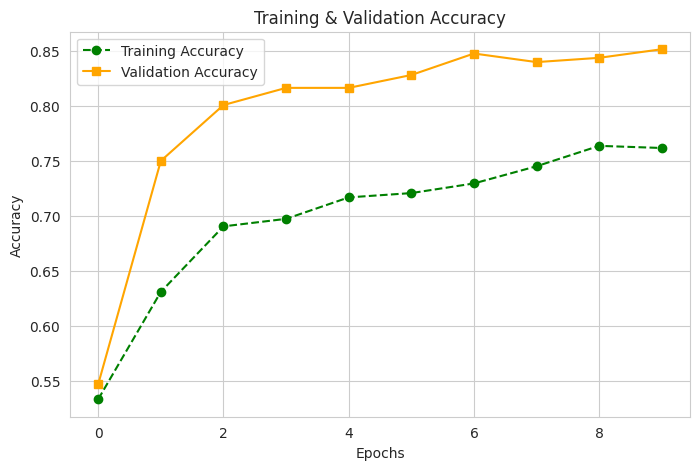

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert training history to DataFrame
history_df = pd.DataFrame(history.history)

# Set Seaborn style for better visualization
sns.set_style("whitegrid")

# 🔥 **Plot Loss**
plt.figure(figsize=(8, 5))
plt.plot(history_df['loss'], label='Training Loss', color='blue', linestyle='--', marker='o')
plt.plot(history_df['val_loss'], label='Validation Loss', color='red', linestyle='-', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

# 🔥 **Plot Accuracy**
plt.figure(figsize=(8, 5))
plt.plot(history_df['accuracy'], label='Training Accuracy', color='green', linestyle='--', marker='o')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='-', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.show()


# Prediction

In [17]:
import numpy as np
import gc
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from math import ceil

# 🔥 **Predict on Validation Set**
y_val_pred = model.predict(x_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)  # Convert probabilities to class indices
y_val_true_classes = np.argmax(y_val, axis=1)

# Compute Accuracy
val_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# 🔥 **Create Test Data Generator**
test_generator = ImageDataGenerator(rescale=1/255.)
test_data = test_generator.flow(x_test, batch_size=BATCH_SIZE, shuffle=False)

# 🔥 **Test-Time Augmentation (TTA)**
steps = 10
predictions = []

for i in tqdm(range(steps)):
    preds = model.predict(test_data, steps=ceil(len(x_test) / BATCH_SIZE), verbose=1)
    predictions.append(preds)

# 🔥 **Average Predictions Across TTA Steps**
y_pred_tta = np.mean(predictions, axis=0)

# 🔥 **Convert to Class Labels**
y_test_pred_classes = np.argmax(y_pred_tta, axis=1)


8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step
Validation Accuracy: 0.5000


  0%|          | 0/10 [00:00<?, ?it/s]

15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step


 10%|█         | 1/10 [00:28<04:15, 28.40s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


 20%|██        | 2/10 [00:29<01:38, 12.33s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


 30%|███       | 3/10 [00:30<00:50,  7.20s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


 40%|████      | 4/10 [00:31<00:29,  4.88s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


 50%|█████     | 5/10 [00:33<00:17,  3.56s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


 60%|██████    | 6/10 [00:34<00:10,  2.75s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


 70%|███████   | 7/10 [00:35<00:06,  2.20s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


 80%|████████  | 8/10 [00:36<00:03,  1.85s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


 90%|█████████ | 9/10 [00:37<00:01,  1.68s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


100%|██████████| 10/10 [00:38<00:00,  3.89s/it]


# Confusion Metrix

8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step
Confusion matrix, without normalization
[[  0 120]
 [  0 120]]


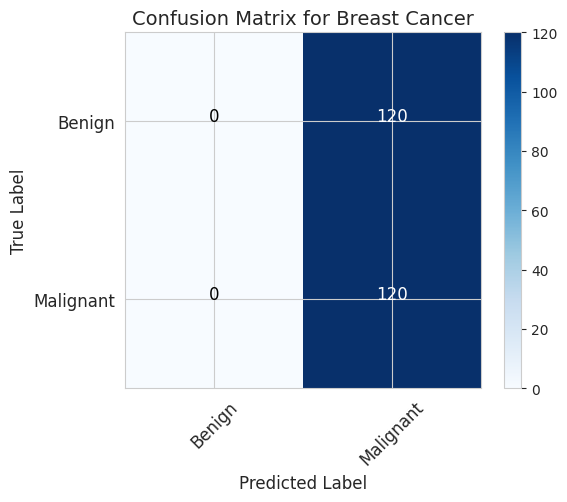

In [19]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Ensure y_pred is computed before using it
y_pred = model.predict(x_test)  # Get predictions
y_pred = np.argmax(y_pred, axis=1)  # Convert softmax probabilities to class labels

# Ensure y_test is also in correct format
y_test_labels = np.argmax(y_test, axis=1)  # If one-hot encoded

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row (true labels)
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0

    # Add text annotations
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 fontsize=12,
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

# Compute Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred)

# Define Class Labels
cm_plot_labels = ['Benign', 'Malignant']

# Plot the Confusion Matrix
plot_confusion_matrix(cm, cm_plot_labels, title="Confusion Matrix for Breast Cancer")


# Classification Report

In [21]:
from sklearn.metrics import classification_report
import numpy as np

# Ensure `y_pred_tta` is computed
if 'y_pred_tta' not in locals():
    print("Error: y_pred_tta is not defined. Computing predictions again.")
    y_pred_tta = model.predict(x_test)  # Compute predictions

# Convert softmax probabilities to discrete class labels
y_pred_tta_labels = np.argmax(y_pred_tta, axis=1)

# Ensure `y_test` is properly formatted as integer labels
y_test_labels = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to integers

# Compute Classification Report
report = classification_report(y_test_labels, y_pred_tta_labels, target_names=['Benign', 'Malignant'])
print(report)


              precision    recall  f1-score   support

      Benign       0.68      0.99      0.80       120
   Malignant       0.98      0.53      0.68       120

    accuracy                           0.76       240
   macro avg       0.83      0.76      0.74       240
weighted avg       0.83      0.76      0.74       240



# ROC Curve

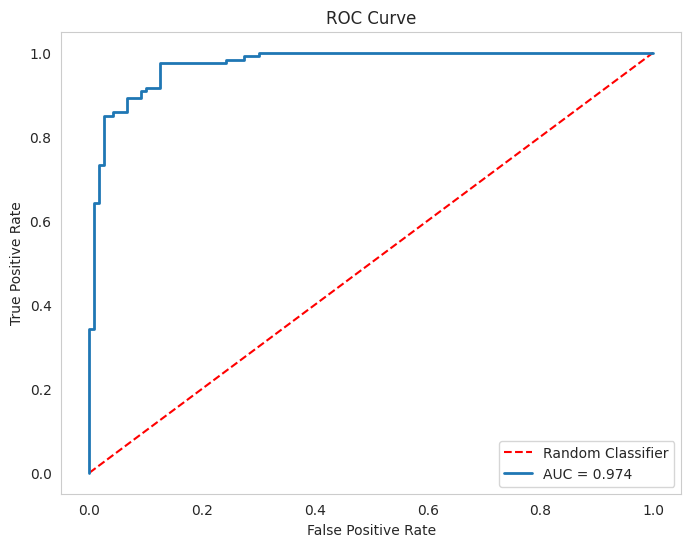

In [22]:
from sklearn.metrics import roc_auc_score, auc, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Ensure y_pred_tta is computed
if 'y_pred_tta' not in locals():
    print("Error: y_pred_tta is not defined. Computing predictions again.")
    y_pred_tta = model.predict(x_test)  # Compute predictions

# Ensure y_test is formatted correctly
y_test_labels = np.argmax(y_test, axis=1)  # Convert one-hot to class labels

# Use predicted probabilities for the positive class (e.g., class index 1)
y_pred_prob = y_pred_tta[:, 1]  # Assuming binary classification (2 classes: 0 & 1)

# Compute AUC-ROC metrics
roc_log = roc_auc_score(y_test_labels, y_pred_prob)
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_labels, y_pred_prob)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'r--', label="Random Classifier")  # Baseline
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve), linewidth=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.grid()
plt.show()


# Saving the Model

In [24]:
model.save("breast_cancer_model.keras")

# Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step


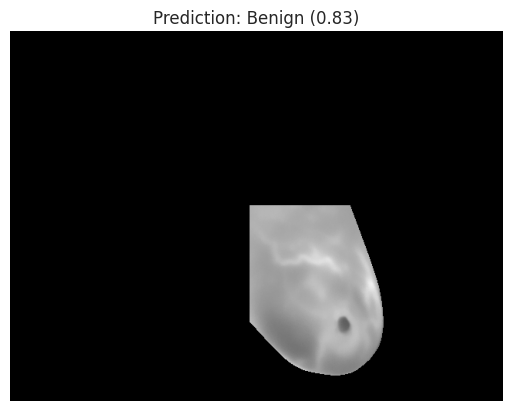

Predicted Class: Benign, Confidence: 0.83


In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the saved model
model = load_model("breast_cancer_model.keras")

# Class labels
class_labels = ["Benign", "Malignant"]

def preprocess_image(img_path, target_size=(224, 224)):  # Change size based on your model
    """Preprocess image for model prediction"""
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize (if your model was trained with normalization)
    return img_array

def predict_image(img_path):
    """Predicts whether the image is benign or malignant"""
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)

    predicted_class = np.argmax(prediction)  # Get the index of the highest probability
    confidence = np.max(prediction)  # Get confidence score

    # Display image
    plt.imshow(image.load_img(img_path))
    plt.axis("off")
    plt.title(f"Prediction: {class_labels[predicted_class]} ({confidence:.2f})")
    plt.show()

    return class_labels[predicted_class], confidence

# Example usage
image_path = "/content/PAC_61_DN0-esq.png"  # Replace with actual path
result, confidence = predict_image(image_path)
print(f"Predicted Class: {result}, Confidence: {confidence:.2f}")
